# LSTM

1. choose a dataset
2. download and check the shape of the dataset
4. clean the data if needed (hint: regex)
5. decide the tokenization strategy (word , character , sub character)
6. build the vocab
7. build a wrapper around the dataset
8. dataloader -> train[0] (input,label)
9. Build network architecture
10. Training loop
11. evaluate


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from collections import Counter
import re

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

# For loading datasets
from datasets import load_dataset

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset = load_dataset(
    "iwslt2017", 
    "iwslt2017-de-en", 
    trust_remote_code=True  
)

train_data = dataset["train"]  
test_data = dataset["test"]


print(f"Sample English: {train_data[2]['translation']['en']}")
print(f"Sample German: {train_data[2]['translation']['de']}")
print(f"\nDataset sizes - Train: {len(train_data)}, Test: {len(test_data)}")

Sample English: I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
Sample German: Ich bin wirklich begeistert von dieser Konferenz, und ich danke Ihnen allen für die vielen netten Kommentare zu meiner Rede vorgestern Abend.

Dataset sizes - Train: 206112, Test: 8079


In [3]:
def preprocess_text(text, lang="en"):
    """Modified from your IMDB function to handle language-specific rules"""
    text = re.sub(r'<.*?>', '', text)  
    text = re.sub(r'[^\w\sßäöüÄÖÜ]', '', text)  # Keep letters + German chars
    
    # Language-specific rules
    if lang == "en":
        text = text.lower()  # English lowercase    
    tokens = word_tokenize(text)
    return tokens


In [4]:
def preprocess_translation_data(dataset):
    """Process all English-German pairs at once, preserving German capitalization"""
    en_texts = []
    de_texts = []
    
    for example in dataset:
        # English (lowercase)
        en_tokens = preprocess_text(example["translation"]["en"], lang="en")
        # German (keep capitalization)
        de_tokens = preprocess_text(example["translation"]["de"], lang="de")
        
        en_texts.append(en_tokens)
        de_texts.append(de_tokens)
    
    return {"en_tokens": en_texts, "de_tokens": de_texts}

# Apply to all data (no batching)
train_data = preprocess_translation_data(dataset["train"]) 
test_data = preprocess_translation_data(dataset["test"])

train_data["en_tokens"][0], train_data["de_tokens"][0]

(['thank', 'you', 'so', 'much', 'chris'], ['Vielen', 'Dank', 'Chris'])

In [5]:
def build_translation_vocabs(en_texts, de_texts, max_words=20000):

    special_tokens = [
        '<PAD>', '<UNK>', '<SOS>', '<EOS>'
    ]
    
    # English vocab
    en_vocab = {token: idx for idx, token in enumerate(special_tokens)}
    en_counter = Counter(token for text in en_texts for token in text)
    for token, _ in en_counter.most_common(max_words - len(special_tokens)):
        if token not in en_vocab:
            en_vocab[token] = len(en_vocab)
    
    # German vocab (maintains capitalization)
    de_vocab = {token: idx for idx, token in enumerate(special_tokens)}
    de_counter = Counter(token for text in de_texts for token in text)
    for token, _ in de_counter.most_common(max_words - len(special_tokens)):
        if token not in de_vocab:
            de_vocab[token] = len(de_vocab)
    
    return en_vocab, de_vocab

en_vocab, de_vocab = build_translation_vocabs(
    train_data["en_tokens"], 
    train_data["de_tokens"]
)

In [6]:
print("English vocab size:", len(en_vocab))
print("German vocab size:", len(de_vocab))
print("\nSample English tokens:", train_data["en_tokens"][0][:10])
print("Sample German tokens:", train_data["de_tokens"][0][:10])
print("\nSpecial tokens shared:")
print(f"<PAD>: EN={en_vocab['<PAD>']}, DE={de_vocab['<PAD>']}")

English vocab size: 20000
German vocab size: 20000

Sample English tokens: ['thank', 'you', 'so', 'much', 'chris']
Sample German tokens: ['Vielen', 'Dank', 'Chris']

Special tokens shared:
<PAD>: EN=0, DE=0


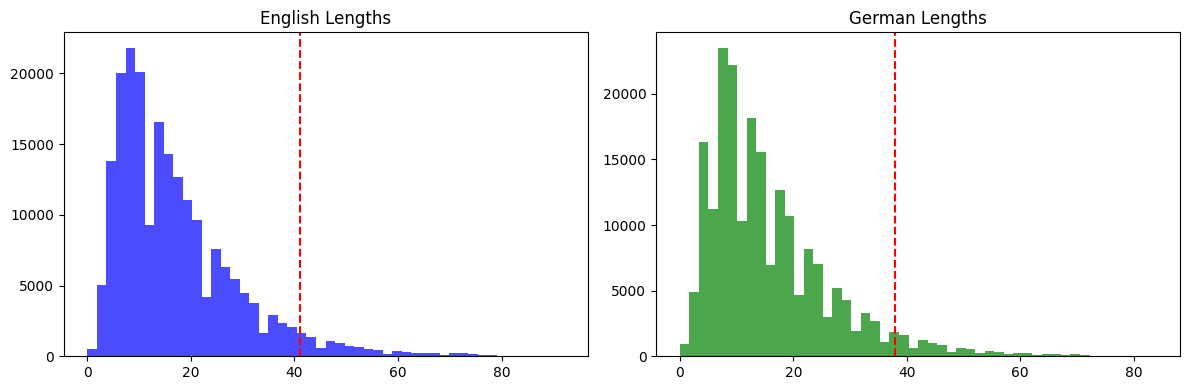

Max lengths - English: 41, German: 38


In [7]:
def analyze_lengths(en_texts, de_texts):
    en_lengths = [len(seq) for seq in en_texts]
    de_lengths = [len(seq) for seq in de_texts]
    
    en_p95 = int(np.percentile(en_lengths, 95))
    de_p95 = int(np.percentile(de_lengths, 95))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(en_lengths, bins=50, color='blue', alpha=0.7)
    plt.axvline(en_p95, color='r', linestyle='--', label=f'95th: {en_p95}')
    plt.title("English Lengths")
    
    plt.subplot(1, 2, 2)
    plt.hist(de_lengths, bins=50, color='green', alpha=0.7)
    plt.axvline(de_p95, color='r', linestyle='--', label=f'95th: {de_p95}')
    plt.title("German Lengths")
    
    plt.tight_layout()
    plt.show()
    
    return en_p95, de_p95

en_max_len, de_max_len = analyze_lengths(train_data["en_tokens"], train_data["de_tokens"])
print(f"Max lengths - English: {en_max_len}, German: {de_max_len}")

In [8]:
def encode(tokens, vocab, max_len, add_special=False):  
    """Converts tokens to padded IDs (exactly like your IMDB encode_review but with <SOS>/<EOS>)."""  
    if add_special:  
        tokens = ["<SOS>"] + tokens + ["<EOS>"]  
    encoded = [vocab.get(token, vocab["<UNK>"]) for token in tokens[:max_len]]  
    encoded += [vocab["<PAD>"]] * (max_len - len(encoded))  
    return encoded  

# Encode all data  
train_en = [encode(seq, en_vocab, en_max_len) for seq in train_data["en_tokens"]]  
train_de = [encode(seq, de_vocab, de_max_len, add_special=True) for seq in train_data["de_tokens"]]  
test_en = [encode(seq, en_vocab, en_max_len) for seq in test_data["en_tokens"]]  
test_de = [encode(seq, de_vocab, de_max_len, add_special=True) for seq in test_data["de_tokens"]]  

In [9]:
train_data = TensorDataset(torch.tensor(train_en), torch.tensor(train_de))  
test_data = TensorDataset(torch.tensor(test_en), torch.tensor(test_de))  

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)  

In [10]:
for src, trg in test_loader:
    
    # Transpose to get [seq_len, batch_size]
    src = src.transpose(0, 1)
    trg = trg.transpose(0, 1)
    print(f"Source shape: {src.shape}, Target shape: {trg.shape}")
    break

Source shape: torch.Size([41, 64]), Target shape: torch.Size([38, 64])


In [11]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super(Encoder, self).__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        # Changed from GRU to LSTM
        self.rnn = nn.LSTM(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        embedded = self.dropout(self.embedding(src))
        
        outputs, (hidden, cell) = self.rnn(embedded)

        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)

        cell = torch.cat((cell[-2,:,:], cell[-1,:,:]), dim=1)
        
        hidden = torch.tanh(self.fc(hidden))
        
        cell = torch.tanh(self.fc(cell))
        
        return outputs, (hidden, cell)

In [12]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super(Attention, self).__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias=False)
        
    def forward(self, hidden, encoder_outputs):
        # hidden = [batch_size, dec_hid_dim]
        # encoder_outputs = [src_len, batch_size, enc_hid_dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        # Repeat hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        # hidden = [batch_size, src_len, dec_hid_dim]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch_size, src_len, enc_hid_dim * 2]
        
        # Calculate energy
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
        # energy = [batch_size, src_len, dec_hid_dim]
        
        attention = self.v(energy).squeeze(2)
        # attention = [batch_size, src_len]
        
        # Return attention weights
        return F.softmax(attention, dim=1)

In [13]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super(Decoder, self).__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        # Changed from GRU to LSTM
        self.rnn = nn.LSTM((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden_cell, encoder_outputs):
        # input = [batch_size]
        # hidden_cell = tuple of ([batch_size, dec_hid_dim], [batch_size, dec_hid_dim])
        # encoder_outputs = [src_len, batch_size, enc_hid_dim * 2]
        
        # Unpack hidden and cell states
        hidden, cell = hidden_cell
        
        # Make input 2D
        input = input.unsqueeze(0)
        # input = [1, batch_size]
        
        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch_size, emb_dim]
        
        # Calculate attention
        a = self.attention(hidden, encoder_outputs)
        # a = [batch_size, src_len]
        
        # Add batch dimension
        a = a.unsqueeze(1)
        # a = [batch_size, 1, src_len]
        
        # Adjust encoder outputs for attention calculation
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        # encoder_outputs = [batch_size, src_len, enc_hid_dim * 2]
        
        # Calculate weighted context vector
        context = torch.bmm(a, encoder_outputs)
        # context = [batch_size, 1, enc_hid_dim * 2]
        
        # Adjust context for concatenation
        context = context.permute(1, 0, 2)
        # context = [1, batch_size, enc_hid_dim * 2]
        
        # Concatenate embedded input and context vector
        rnn_input = torch.cat((embedded, context), dim=2)
        # rnn_input = [1, batch_size, (enc_hid_dim * 2) + emb_dim]
        
        # Prepare hidden and cell states for LSTM input
        hidden_tensor = hidden.unsqueeze(0)
        cell_tensor = cell.unsqueeze(0)
        
        # Pass through LSTM
        output, (hidden_new, cell_new) = self.rnn(rnn_input, (hidden_tensor, cell_tensor))
        # output = [1, batch_size, dec_hid_dim]
        # hidden_new = [1, batch_size, dec_hid_dim]
        # cell_new = [1, batch_size, dec_hid_dim]
        
        # Remove sequence dimension
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        context = context.squeeze(0)
        
        # Make final prediction
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))
        # prediction = [batch_size, output_dim]
        
        # Return prediction and the new hidden/cell states
        return prediction, (hidden_new.squeeze(0), cell_new.squeeze(0))

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        # src = [src_len, batch_size]
        # trg = [trg_len, batch_size]
        
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        # Encode source sequences
        encoder_outputs, (hidden, cell) = self.encoder(src)
        
        # First decoder input is the < SOS > token
        input = trg[0]
        
        # Start from second token (index 1)
        for t in range(1, trg_len):
            # Pass through decoder
            output, (hidden, cell) = self.decoder(input, (hidden, cell), encoder_outputs)
            
            # Store output
            outputs[t] = output
            
            # Decide whether to use teacher forcing
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            
            # Get the highest predicted token
            top1 = output.argmax(1)
            
            # Use actual token or predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, (src, trg) in enumerate(iterator):
        src, trg = src.to(model.device), trg.to(model.device)
        
        optimizer.zero_grad()
        
        # Forward pass
        output = model(src.transpose(0, 1), trg.transpose(0, 1))
        
        # Calculate loss
        output_dim = output.shape[-1]
        
        # Reshape for loss calculation
        output = output[1:].view(-1, output_dim)
        trg = trg.transpose(0, 1)[1:].reshape(-1)
        
        # Calculate loss
        loss = criterion(output, trg)
        
        # Backpropagation
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        # Update parameters
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [18]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, (src, trg) in enumerate(iterator):
            src, trg = src.to(model.device), trg.to(model.device)
            
            # Forward pass
            output = model(src.transpose(0, 1), trg.transpose(0, 1), 0) # no teacher forcing
            
            # Calculate loss
            output_dim = output.shape[-1]
            
            # Reshape for loss calculation
            output = output[1:].view(-1, output_dim)
            trg = trg.transpose(0, 1)[1:].reshape(-1)
            
            # Calculate loss
            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
# Modified BLEU calculation function to handle LSTM states
def calculate_bleu(model, iterator, trg_vocab, device):
    
    model.eval()
    predictions = []
    references = []
    idx_to_word = {idx: word for word, idx in trg_vocab.items()}
    
    with torch.no_grad():
        for src, trg in iterator:
            src, trg = src.to(device), trg.to(device)
            
            # Transpose to get [seq_len, batch_size]
            src = src.transpose(0, 1)
            trg = trg.transpose(0, 1)
            
            # Get encoder outputs and hidden/cell states
            encoder_outputs, (hidden, cell) = model.encoder(src)
            
            # First input is < SOS > token
            input = trg[0]
            
            # List to store predicted tokens
            pred_tokens = []
            
            # Maximum prediction length (to avoid infinite loops)
            max_len = 50
            
            # Decode one token at a time
            for t in range(1, max_len):
                output, (hidden, cell) = model.decoder(input, (hidden, cell), encoder_outputs)
                
                pred_token = output.argmax(1)
                pred_tokens.append(pred_token)
                input = pred_token
                
            # Convert token indices to words
            pred_sentences = []
            ref_sentences = []
            
            # Process each sentence in the batch
            for i in range(src.shape[1]):
                # Prediction
                pred_sent = []
                for t in range(len(pred_tokens)):
                    token = pred_tokens[t][i].item()
                    if token == trg_vocab["<EOS>"]:
                        break
                    elif token not in [trg_vocab["<PAD>"], trg_vocab["<SOS>"]]:
                        pred_sent.append(idx_to_word.get(token, "<UNK>"))
                
                # Reference
                ref_sent = []
                for t in range(1, trg.shape[0]):
                    token = trg[t][i].item()
                    if token == trg_vocab["<EOS>"]:
                        break
                    elif token not in [trg_vocab["<PAD>"], trg_vocab["<SOS>"]]:
                        ref_sent.append(idx_to_word.get(token, "<UNK>"))
                
                # Only add valid sentences
                if pred_sent and ref_sent:
                    predictions.append(pred_sent)
                    references.append([ref_sent])
    
    # Calculate BLEU score
    if not predictions:
        return 0.0
    
    smoothing = SmoothingFunction().method4
    return corpus_bleu(references, predictions, smoothing_function=smoothing)

In [20]:
def initialize_lstm_model(input_dim, output_dim, en_max_len, de_max_len):
    # Create attention, encoder, decoder
    attention = Attention(512, 512)
    encoder = Encoder(input_dim, 256, 512, 0.5)
    decoder = Decoder(output_dim, 256, 512, 512, 0.5, attention)

    # Create the Seq2Seq model
    model = Seq2Seq(encoder, decoder, device).to(device)

    # Initialize weights
    def init_weights(m):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)
                
    model.apply(init_weights)

    # Print model details
    print(f"The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters")
    
    return model

In [21]:
def translate_sentence(sentence, model, en_vocab, de_vocab, device, max_length=50):
    """
    Translates a sentence from English to German using the model
    """
    # Preprocess the sentence
    tokens = preprocess_text(sentence, lang="en")
    de_idx_to_word = {idx: word for word, idx in de_vocab.items()}

    # Encode with same parameters as training
    encoded = [encode(tokens, en_vocab, en_max_len)]
    enc_tensor = torch.tensor(encoded).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Prepare input for encoder (transpose to get [seq_len, batch_size])
        src_tensor = enc_tensor.transpose(0, 1)
        
        # Get encoder outputs and hidden/cell states
        encoder_outputs, (hidden, cell) = model.encoder(src_tensor)
        
        # Start with SOS token
        input = torch.tensor([de_vocab["<SOS>"]]).to(device)
        
        # Store generated tokens
        translated_tokens = []
        
        # Generate tokens one at a time
        for _ in range(max_length):
            # Get prediction from decoder
            output, (hidden, cell) = model.decoder(input, (hidden, cell), encoder_outputs)
            
            # Get most likely word
            pred_token = output.argmax(1)
            
            # Convert to integer
            token_id = pred_token.item()
            
            # Stop if EOS token
            if token_id == de_vocab["<EOS>"]:
                break
                
            # Add to results if not a special token
            if token_id not in [de_vocab["<PAD>"], de_vocab["<SOS>"]]:
                translated_tokens.append(token_id)
                
            # Use predicted token as next input
            input = pred_token
    
    # Convert IDs to words
    translated_words = [de_idx_to_word.get(idx, "<UNK>") for idx in translated_tokens]
    
    # Format the final sentence
    if not translated_words:
        return ""  # Empty if no valid words
    
    # Join words and fix German formatting
    sentence = " ".join(translated_words)
    sentence = re.sub(r' (?=[\.,!?])', '', sentence)  # Fix punctuation spacing
    return sentence.capitalize()  # Capitalize first letter

In [22]:
input_dim = len(en_vocab)
output_dim = len(de_vocab)
model = initialize_lstm_model(input_dim, output_dim, en_max_len, de_max_len)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=de_vocab["<PAD>"])

# Training parameters
epochs = 5
clip = 1.0

# Training loop
for epoch in range(epochs):
    print(f'Epoch {epoch+1}:')

    train_loss = train(model, train_loader, optimizer, criterion, clip)
    print(f'\tTrain Loss: {train_loss:.4f}')

    valid_loss = evaluate(model, test_loader, criterion)
    print(f'\tValid Loss: {valid_loss:.4f}')

    bleu = calculate_bleu(model, test_loader, de_vocab, device)
    print(f'\tBLEU Score: {bleu*100:.2f}%')


The model has 54,240,288 trainable parameters
Epoch 1:
	Train Loss: 5.2481
	Valid Loss: 4.6774
	BLEU Score: 8.59%
Epoch 2:
	Train Loss: 3.9870
	Valid Loss: 4.3589
	BLEU Score: 12.21%
Epoch 3:
	Train Loss: 3.5043
	Valid Loss: 4.3246
	BLEU Score: 14.04%
Epoch 4:
	Train Loss: 3.2212
	Valid Loss: 4.2925
	BLEU Score: 14.48%
Epoch 5:
	Train Loss: 3.0151
	Valid Loss: 4.3488
	BLEU Score: 14.53%


In [23]:

# Save the model
torch.save(model.state_dict(), "translation_lstm_model.pt")


In [ ]:

# Test translation
english_sentence = "I am so proud of what I have done."
translation = translate_sentence(english_sentence, model, en_vocab, de_vocab, device)
print(f"English: {english_sentence}")
print(f"German: {translation}")

English: I am so proud of what i have done.
German: Ich bin so stolz darauf was ich getan habe
